Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special

# Helper Functions

In [ ]:
def KL(mu, nu, dist='Gaussian'):
  """
  Parameters
  ----------
  mu, nu:
    array of size (K, n_instances), where K is the number of arms,
    and n_instances is the number of problem instances.
    values denote the expected reward of arms.
  """
  if dist == 'Gaussian':
    return (mu-nu)**2/2
  elif dist == 'Bernoulli':
    return mu*np.log(mu/nu) + (1-mu)*np.log((1-mu)/(1-nu))
  elif dist == 'Exponential':
    return np.log(mu/nu) + nu/mu - 1

def KLRatio(mu, w, dist='Gaussian'):
  """
  Parameters
  ----------
  mu:
    array of size (K, n_instances), where K is the number of arms,
    and n_instances is the number of problem instances.
    values denote the expected reward of arms.
  w:
    array of size (K, n_instances).
    values denote the weight of each arm

  Output
  -------
  KL(mu1, (w1*mu1+wa*mua)/(w1+wa))/KL(mua, (w1*mu1+wa*mua)/(w1+wa)) for every arm a
  """
  K = mu.shape[0]
  n = mu.shape[1]
  best_arm_idx = np.argmax(mu, axis=0)
  w_best = w[best_arm_idx, np.arange(n)]
  mu_best = mu[best_arm_idx, np.arange(n)]
  mu_avg = (w*mu+(w_best*mu_best)[None,:])/(w+w_best[None,:])

  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)

def KLObjective(mu, w, dist='Gaussian'):
  """
  Parameters
  ----------
  mu:
    array of size (K, n_instances), where K is the number of arms,
    and n_instances is the number of problem instances.
    values denote the expected reward of arms.
  w:
    array of size (K, n_instances).
    values denote the weight of each arm

  Output
  -------
  w1*KL(mu1, (w1*mu1+wa*mua)/(w1+wa)) + wa* KL(mua, (w1*mu1+wa*mua)/(w1+wa)) for every arm a
  """
  K = mu.shape[0]
  n = mu.shape[1]
  best_arm_idx = np.argmax(mu, axis=0)
  w_best = w[best_arm_idx, np.arange(n)]
  mu_best = mu[best_arm_idx, np.arange(n)]
  mu_avg = (w*mu+(w_best*mu_best)[None,:])/(w+w_best[None,:])

  return w_best[None,:]*KL(mu_best[None,:], mu_avg, dist) + w*KL(mu, mu_avg, dist)

def KLObjectiveGrad(mu, w, dist='Gaussian'):
  """
  Parameters
  ----------
  mu:
    array of size (K, n_instances), where K is the number of arms,
    and n_instances is the number of problem instances.
    values denote the expected reward of arms.
  w:
    array of size (K, n_instances).
    values denote the weight of each arm

  Output
  -------
  [KL(mu1, (w1*mu1+wa*mua)/(w1+wa)), KL(mua, (w1*mu1+wa*mua)/(w1+wa))]
  where a is the arm with the smallest index
  """
  K = mu.shape[0]
  n = mu.shape[1]
  best_arm_idx = np.argmax(mu, axis=0)
  w_best = w[best_arm_idx, np.arange(n)]
  mu_best = mu[best_arm_idx, np.arange(n)]
  mu_avg = (w*mu+(w_best*mu_best)[None,:])/(w+w_best[None,:])

  t1 = KL(mu_best[None,:], mu_avg, dist)
  t2 = KL(mu, mu_avg, dist)
  kl_obj = w_best[None,:]*t1 + w*t2
  kl_obj[best_arm_idx, np.arange(n)] = np.Inf
  competitors = np.argmin(kl_obj, axis=0)
  result = np.zeros_like(w)
  result[best_arm_idx, np.arange(n)] = t1[competitors, np.arange(n)]
  result[competitors, np.arange(n)] = t2[competitors, np.arange(n)]
  return result



# max-min solvers

In [ ]:
class OfflineOnlineMaxMinSolver(object):
    def __init__(self, mu, delta, n_offline, dist='Gaussian'):
        """
        Parameters
        ----------
        mu:
            array of size (K, n_instances), where K is the number of arms,
            and n_instances is the number of problem instances.
            values denote the expected reward of arms.
        delta:
            confidence parameter (scalar)
        n_offline:
            array of size (K, n_instances).
            number of offline samples available for each arm
        dist:
            distribution of the arms (string)
            options: [Gaussian, Bernoulli, Exponential]
        """
        self.mu = mu

        self.K = mu.shape[0]
        self.n_instances = mu.shape[1]
        self.best_arm_idx = np.argmax(self.mu, axis=0)

        self.delta = delta
        self.beta = -np.log(delta) + np.log(-np.log(delta))

        self.n_offline = n_offline
        self.dist = dist

        self.n_upper_bound = 1e10

    def _na_star(self, n1_online, tol=1e-6):
        # do bisection search to find Na*(N1)
        n_total_lb = np.zeros_like(self.mu)
        n_total_ub = self.n_upper_bound*np.ones_like(self.mu)
        constraint_error = np.zeros_like(self.mu) # store the error in the constraint

        n1_offline = self.n_offline[self.best_arm_idx, np.arange(self.n_instances)]
        n1_total = n1_offline + n1_online
        n_total_lb[self.best_arm_idx, np.arange(self.n_instances)] = n1_total
        n_total_ub[self.best_arm_idx, np.arange(self.n_instances)] = n1_total

        while np.any(n_total_ub - n_total_lb > tol):
          # determine the next point for bisection search
          n_total_next = 0.5*(n_total_lb+n_total_ub)
          idx_inf = np.where(n_total_ub == np.Inf)
          n_total_next[idx_inf] = np.maximum(2*n_total_lb[idx_inf], 1)
          n_total_next[idx_inf] = np.minimum(n_total_next[idx_inf], self.n_upper_bound)

          # do bisection search based on the constraint value
          constraint = KLObjective(self.mu, n_total_next, self.dist)
          constraint_error = np.abs(constraint - self.beta)
          constraint_error[self.best_arm_idx, np.arange(self.n_instances)] = 0

          idx_neg = np.where((constraint <= self.beta))
          idx_pos = np.where((constraint > self.beta))
          n_total_lb[idx_neg] = n_total_next[idx_neg]
          n_total_ub[idx_pos] = n_total_next[idx_pos]


        return 0.5*(n_total_lb+n_total_ub) - n_offline, constraint_error

    def _n1_sub_grad(self, n1_online, tol=1e-6):
        # computes the gradient of N1+sum_{a>1} Na*(N1) w.r.t N1
        n_online, constraint_error = self._na_star(n1_online, tol)
        kl_ratio = KLRatio(self.mu, self.n_offline + n_online, self.dist)

        inactive_arms = np.where(n_online <= 0)
        kl_ratio[inactive_arms] = 0
        kl_ratio[self.best_arm_idx, np.arange(self.n_instances)] = -1

        sub_grad = -np.sum(kl_ratio, axis=0)

        # if there exists any constraint that isn't satisfied, increase n1
        idx_bad = np.where(np.any(constraint_error > 1e-3, axis = 0))
        sub_grad[idx_bad] = -1
        return sub_grad

    def compute_optimal_proportions(self, tol=1e-2, algo='bisection'):
        if algo == 'bisection':
          # lower and upper bounds for n1 (number of online samples of the best arm)
          n1_lb = np.zeros(self.n_instances)
          n1_ub = self.n_upper_bound*np.ones(self.n_instances)
          while np.any(n1_ub - n1_lb > tol):
            # determine the next point for bisection search
            n1_next = 0.5*(n1_lb+n1_ub)
            idx_inf = np.where(n1_ub == np.Inf)
            n1_next[idx_inf] = np.maximum(2*n1_lb[idx_inf], 1)

            # do bisection search based on the sign of the gradients
            n1_grad = self._n1_sub_grad(n1_next)
            idx_neg_grad = np.where((n1_grad <= 0))
            idx_pos_grad = np.where((n1_grad > 0))
            n1_lb[idx_neg_grad] = n1_next[idx_neg_grad]
            n1_ub[idx_pos_grad] = n1_next[idx_pos_grad]

          optimal_proportions, _ = self._na_star(0.5*(n1_lb+n1_ub))
          return optimal_proportions


In [ ]:
class OnlineMaxMinSolver(object):
    def __init__(self, mu, delta, dist='Gaussian'):
        """
        Parameters
        ----------
        mu:
            array of size (K, n_instances), where K is the number of arms,
            and n_instances is the number of problem instances.
            values denote the expected reward of arms.
        delta:
            confidence parameter (scalar)
        n_offline:
            array of size (K, n_instances)
        dist:
            distribution of the arms (string)
            options: [Gaussian, Bernoulli, Exponential]
        """
        self.mu = mu

        self.K = mu.shape[0]
        self.n_instances = mu.shape[1]
        self.best_arm_idx = np.argmax(self.mu, axis=0)

        self.delta = delta
        self.beta = -np.log(delta) + np.log(-np.log(delta))

        self.dist = dist


    def compute_optimal_proportions(self, iters=10000, algo='Top2'):
        if algo == 'FW': # FW doesn't work theoretically
          w = np.ones_like(self.mu)/self.K
          for i in range(1, iters):
            kl_ratio = KLRatio(self.mu, w, self.dist)
            kl_ratio[self.best_arm_idx, np.arange(self.n_instances)] = 0
            kl_objective = KLObjective(self.mu, w, self.dist)
            kl_objective[self.best_arm_idx, np.arange(self.n_instances)] = np.Inf

            idx = np.argmin(kl_objective, axis=0)
            idx1 = np.where(kl_ratio[idx, np.arange(self.n_instances)] >= 1)
            w_next = i*w
            w_next[self.best_arm_idx[idx1], idx1] += 1

            idx2 = np.where(kl_ratio[idx, np.arange(self.n_instances)] < 1)
            w_next[idx[idx2[0]], idx2] += 1
            w = w_next/(i+1)

          return w
        elif algo == 'TCB': # Transportation Cost Balancing
          w = np.ones_like(self.mu)/self.K
          for i in range(1, iters):
            kl_objective = KLObjective(self.mu, w, self.dist)
            kl_objective[self.best_arm_idx, np.arange(self.n_instances)] = np.Inf
            idx = np.argmin(kl_objective, axis=0)

            # w counterfactual for challenger
            w_cf_ch = i*w
            w_cf_ch[idx, np.arange(self.n_instances)]  += 1
            w_cf_ch /= i+1
            kl_objective_cf_ch = KLObjective(self.mu, w_cf_ch, self.dist)
            kl_objective_cf_ch[self.best_arm_idx, np.arange(self.n_instances)] = np.Inf
            kl_objective_cf_ch = np.ndarray.min(kl_objective_cf_ch, axis=0)
            # w counterfactual for best arm
            w_cf_eba = i*w
            w_cf_eba[self.best_arm_idx, np.arange(self.n_instances)] += 1
            w_cf_eba /= i+1
            kl_objective_cf_eba = KLObjective(self.mu, w_cf_eba, self.dist)
            kl_objective_cf_eba[self.best_arm_idx, np.arange(self.n_instances)] = np.Inf
            kl_objective_cf_eba = np.ndarray.min(kl_objective_cf_eba, axis=0)

            # pull arms based on the counterfactual objective values
            idx1 = np.where(kl_objective_cf_ch < kl_objective_cf_eba)
            w_next = i*w
            w_next[self.best_arm_idx[idx1], idx1] += 1

            idx2 = np.where(kl_objective_cf_ch > kl_objective_cf_eba)
            w_next[idx[idx2[0]], idx2] += 1
            w = w_next/(i+1)

          return w
        elif algo == 'Top2':
          w = np.ones_like(self.mu)/self.K
          for i in range(1, iters):
            kl_ratio = KLRatio(self.mu, w, self.dist)
            kl_ratio[self.best_arm_idx, np.arange(self.n_instances)] = 0
            sum_kl_ratio = np.sum(kl_ratio, axis=0)
            kl_objective = KLObjective(self.mu, w, self.dist)
            kl_objective[self.best_arm_idx, np.arange(self.n_instances)] = np.Inf

            # pull arm 1 if the sum_kl_ratio is greater than 1
            idx1 = np.where(sum_kl_ratio > 1)
            w_next = i*w
            w_next[self.best_arm_idx[idx1], idx1] += 1
            w_next[:, idx1] /= (i+1)

            # otherwise pull a competitor
            idx2 = np.where(sum_kl_ratio <= 1)
            idx2_ = idx2[0]
            if idx2_.size == 0:
              w = w_next
              continue
            for j in range(idx2_.size):
              arm_pull = np.argmin(kl_objective[:, idx2_[j]])
              w_next[arm_pull, idx2_[j]] += 1
            w_next[:, idx2] /= (i+1)
            w = w_next

          return w
        elif algo == 'EWA': # exponential weights algorithm
          w = np.ones_like(self.mu)/self.K
          g = np.zeros_like(self.mu)
          for i in range(1, iters):
            eta = i**0.5
            g = g + KLObjectiveGrad(self.mu, w, self.dist)
            w = sp.special.softmax(eta*g, axis=0)
          return w
        elif algo == 'OEWA': # optimistic exponential weights algorithm
          w = np.ones_like(self.mu)/self.K
          g = np.zeros_like(self.mu)
          g_curr = np.zeros_like(self.mu)
          for i in range(1, iters):
            eta = i**0.5
            g_curr = KLObjectiveGrad(self.mu, w, self.dist)
            g = g + g_curr
            w = sp.special.softmax(eta*(g+g_curr), axis=0)
          return w


# Test max-min solvers
### Generate Problem Instances

In [ ]:
# generate the problem instance
K = 10 # number of arms
delta = 0.03 # gap between arms
mu = np.random.uniform(0.0+delta, 1.0 - delta, K) # expected reward of the arms
mu = -np.sort(-mu)
mu[0] = 1-delta/2

In [ ]:
# run bisection search
mu_rep = np.hstack((mu[:,None], mu[:, None]))
n_offline = np.zeros_like(mu_rep)
bisection_solver = OfflineOnlineMaxMinSolver(mu = mu_rep, delta = 1e-6, n_offline=n_offline, dist='Gaussian')
opt_props = bisection_solver.compute_optimal_proportions()
print(opt_props/np.sum(opt_props, axis=0)[None,:])

[[0.35550507 0.35550507]
 [0.30020812 0.30020812]
 [0.17459908 0.17459908]
 [0.04801803 0.04801803]
 [0.04122606 0.04122606]
 [0.03393357 0.03393357]
 [0.01778661 0.01778661]
 [0.01232372 0.01232372]
 [0.01088406 0.01088406]
 [0.00551567 0.00551567]]


<ipython-input-78-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


In [ ]:
# run top2
Top2_solver = OnlineMaxMinSolver(mu = mu_rep, delta = 1e-6, dist='Gaussian')
Top2_opt_props = Top2_solver.compute_optimal_proportions(algo='Top2')
print(Top2_opt_props/np.sum(Top2_opt_props, axis=0)[None,:])


[[0.35541 0.35541]
 [0.30011 0.30011]
 [0.17451 0.17451]
 [0.04801 0.04801]
 [0.04121 0.04121]
 [0.03401 0.03401]
 [0.01781 0.01781]
 [0.01241 0.01241]
 [0.01091 0.01091]
 [0.00561 0.00561]]


<ipython-input-78-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


In [ ]:
# run FW
FW_solver = OnlineMaxMinSolver(mu = mu_rep, delta = 1e-6, dist='Gaussian')
FW_opt_props = FW_solver.compute_optimal_proportions(algo='FW', iters=50000)
print(FW_opt_props/np.sum(FW_opt_props, axis=0)[None,:])


[[0.323862 0.323862]
 [0.323842 0.323842]
 [0.181942 0.181942]
 [0.048382 0.048382]
 [0.041462 0.041462]
 [0.034062 0.034062]
 [0.017782 0.017782]
 [0.012302 0.012302]
 [0.010862 0.010862]
 [0.005502 0.005502]]


<ipython-input-78-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


In [ ]:
# run TCB
TCB_solver = OnlineMaxMinSolver(mu = mu_rep, delta = 1e-6, dist='Gaussian')
TCB_opt_props = TCB_solver.compute_optimal_proportions(algo='TCB', iters=50000)
print(TCB_opt_props/np.sum(TCB_opt_props, axis=0)[None,:])


[[0.432662 0.432662]
 [0.250222 0.250222]
 [0.154882 0.154882]
 [0.045542 0.045542]
 [0.039262 0.039262]
 [0.032442 0.032442]
 [0.017162 0.017162]
 [0.011922 0.011922]
 [0.010542 0.010542]
 [0.005362 0.005362]]


# BAI-MAB
### **Code only works for a single bandit instance. Can't simultaneously solve multiple bandit instances**

In [ ]:
def beta(N, delta):
  K = len(N);
  t = sum(N);
  # beta = np.log(K-1) -np.log(delta) + 6*np.log(1 + np.log(t/2)) + 8*np.log(1 + np.log((K-1)/delta));
  beta = np.log(K-1) - np.log(delta) + np.log(1 + np.log(t));
  return beta

# Define a Stopping condition function.
def Stop(mu, N, delta, dist):
  """
  mu : bandit instance
  N : number of samples to each arm
  delta : bound on error probability
  """

  K = len(N);
  t = sum(N);
  w = N/t;
  glrt = t*KLObjective(mu, w, dist);
  best_idx = np.argmax(mu);
  # index for best arm will always be minimum (~ 0). Exclude that.
  glrt[best_idx] = float('inf')
  m = min(glrt);
  threshold = beta(N,delta)

  return m >= threshold

def track(w, N):
  """
  w : weight to track
  N : number of samples to each arm
  returns the arm to pull
  """
  K = len(N);
  t = sum(N);
  return np.argmax(w/N);

def sample(mu, dist, idx):
  """
  mu : mean vector
  dist : class of SPEF
  idx : index to sample from
  """
  # Generate a sample from distribution dist with mean mu[idx]
  if dist == 'Gaussian':
    return np.random.normal(mu[idx], 1);
  elif dist == 'Bernoulli':
    return np.random.binomial(1, mu[idx]);
  elif dist == 'Exponential':
    return np.random.exponential(scale=mu[idx], size=1)

# Online+Offline Bisection Search

In [ ]:
def batched_tas(mu, K, mu_hat, n_offline, dist, delta):
  """
  mu : mean vector
  mu_hat : emp. mean from offline samples
  K : number of arms
  n_offline : number of offline samples from each arm
  dist : SPEF
  delta : error bound
  """

  N = n_offline; # array to store number of samples for each arm
  w = np.zeros_like(mu); # store the average w (to be tracked)
  wt = np.zeros_like(mu); # store the current w

  for at in range(0,K):
    X = sample(mu, dist, at);
    mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
    N[at] += 1;

  w = 1/K * np.ones_like(mu);
  wt = w;
  t = K;

  while (not Stop(mu_hat, N, delta, dist)):
    if float(np.sqrt(np.floor(t/K))).is_integer():
      print(t, "~~~~~~~ Entering Forced Exploration ~~~~~~~")
      t_ = 0;
      while (t_ < K):
        # Forced Exploration
        wt = 1/K * np.ones_like(mu);

        w = (1-1/(t+t_))*w + 1/(t+t_)*wt #np.array([(1-1/(t+t_))*w[x] + 1/(t+t_)*wt[x] for x in range(0,K)]);
        at = track(w, N);
        X = sample(mu, dist, at);
        mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
        N[at] += 1;
        t_ += 1;
      t += K;
      print(t, "~~~~~~~ Completed FE, computing oracle weights ~~~~~~~")

      bisection_solver = OfflineOnlineMaxMinSolver(mu_hat, 1e-6, n_offline, dist);
      wt = bisection_solver.compute_optimal_proportions();
    else:
      w = (1-1/t)*w + (1/t)*wt # np.array([(1-1/(t))*w[x] + 1/(t)*wt[x] for x in range(0,K)]);
      at = track(w,N);
      X = sample(mu, dist, at);
      mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
      N[at] += 1;
      t += 1;

  return np.argmax(mu_hat, axis=0), t;

# Online Top2

In [ ]:
# Implement top2
def online_top2(mu, K, dist, delta):
  """
  mu : mean vector
  K : number of arms
  dist : SPEF (Gaussian or Bernoulli)
  delta : error bound
  """

  N = np.zeros_like(mu); # array to store number of samples for each arm
  mu_hat = np.zeros_like(mu); # store estimated means
  n_instances = 1
  t=0

  # Sample each arm once
  for at in range(0,K):
    X = sample(mu, dist, at);
    mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
    N[at] += 1;

  t = K;

  while (not Stop(mu_hat, N, delta, dist)):
    best_arm_idx = np.argmax(mu_hat);
    # Check ratio constraint
    kl_ratio = KLRatio(mu_hat, N/np.sum(N), dist)
    kl_ratio[best_arm_idx, np.arange(n_instances)] = 0
    sum_kl_ratio = np.sum(kl_ratio, axis=0)
    kl_objective = KLObjective(mu_hat, N/np.sum(N), dist)
    kl_objective[best_arm_idx, np.arange(n_instances)] = np.Inf

    # can't implement this using if else?
    # pull best arm if the sum_kl_ratio is greater than 1
    if sum_kl_ratio > 1:
      # pull best arm
      X = sample(mu, dist, best_arm_idx)
      mu_hat[best_arm_idx] = (mu_hat[best_arm_idx] * N[best_arm_idx] + X)/(N[best_arm_idx] + 1)
      N[best_arm_idx] += 1
    else:
      competitor = np.argmin(kl_objective)
      X = sample(mu, dist, competitor)
      mu_hat[competitor] = (mu_hat[competitor] * N[competitor] + X)/(N[competitor] + 1)
      N[competitor] += 1

    t += 1
    if float(np.sqrt(np.floor(t/K))).is_integer():
      #print(t, "~~~~~~~ Entering Forced Exploration ~~~~~~~")
      t_ = 0;
      while (t_ < K):
        at = t_
        X = sample(mu, dist, at);
        mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
        N[at] += 1;
        t_ += 1;
      t += K;
      #print(t, "~~~~~~~ Completed FE, computing oracle weights ~~~~~~~")

  print('arm sampling proportions')
  print(N/np.sum(t))
  return np.argmax(mu_hat, axis=0), t;

# FW

In [ ]:
# Implement top2
def online_FW(mu, K, dist, delta):
  """
  mu : mean vector
  K : number of arms
  dist : SPEF (Gaussian or Bernoulli)
  delta : error bound
  """

  N = np.zeros_like(mu); # array to store number of samples for each arm
  mu_hat = np.zeros_like(mu); # store estimated means
  n_instances = 1
  t=0

  # Sample each arm once
  for at in range(0,K):
    X = sample(mu, dist, at);
    mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
    N[at] += 1;

  t = K;

  while (not Stop(mu_hat, N, delta, dist)):
    best_arm_idx = np.argmax(mu_hat);
    # Check ratio constraint
    kl_ratio = KLRatio(mu_hat, N/np.sum(N), dist)
    kl_ratio[best_arm_idx, np.arange(n_instances)] = 0
    kl_objective = KLObjective(mu_hat, N/np.sum(N), dist)
    kl_objective[best_arm_idx, np.arange(n_instances)] = np.Inf
    idx = np.argmin(kl_objective)

    # can't implement this using if else?
    # pull best arm if the sum_kl_ratio is greater than 1
    if kl_ratio[idx] > 1:
      # pull best arm
      X = sample(mu, dist, best_arm_idx)
      mu_hat[best_arm_idx] = (mu_hat[best_arm_idx] * N[best_arm_idx] + X)/(N[best_arm_idx] + 1)
      N[best_arm_idx] += 1
    else:
      competitor = np.argmin(kl_objective)
      X = sample(mu, dist, competitor)
      mu_hat[competitor] = (mu_hat[competitor] * N[competitor] + X)/(N[competitor] + 1)
      N[competitor] += 1

    t += 1
    if float(np.sqrt(np.floor(t/K))).is_integer():
      #print(t, "~~~~~~~ Entering Forced Exploration ~~~~~~~")
      t_ = 0;
      while (t_ < K):
        at = t_
        X = sample(mu, dist, at);
        mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
        N[at] += 1;
        t_ += 1;
      t += K;
      #print(t, "~~~~~~~ Completed FE, computing oracle weights ~~~~~~~")

  print('arm sampling proportions')
  print(N/np.sum(t))
  return np.argmax(mu_hat, axis=0), t;

# Online Transportation cost balancing (TCB)

In [ ]:
# Implement TCB
def online_tcb(mu, K, dist, delta):
  """
  mu : mean vector
  K : number of arms
  dist : SPEF (Gaussian or Bernoulli)
  delta : error bound
  """

  N = np.zeros_like(mu); # array to store number of samples for each arm
  mu_hat = np.zeros_like(mu); # store estimated means
  n_instances = 1
  t=0

  # Sample each arm once
  for at in range(0,K):
    X = sample(mu, dist, at);
    mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
    N[at] += 1;

  t = K;

  while (not Stop(mu_hat, N, delta, dist)):
    best_arm_idx = np.argmax(mu_hat);

    kl_objective = KLObjective(mu_hat, N/np.sum(N), dist)
    kl_objective[best_arm_idx] = np.Inf
    idx = np.argmin(kl_objective)

    # w counterfactual for challenger
    w_cf_ch = np.copy(N)
    w_cf_ch[idx]  += 1
    w_cf_ch /= (np.sum(N) +1)
    kl_objective_cf_ch = KLObjective(mu_hat, w_cf_ch, dist)
    kl_objective_cf_ch[best_arm_idx] = np.Inf
    kl_objective_cf_ch = np.ndarray.min(kl_objective_cf_ch, axis=0)
    # w counterfactual for best arm
    w_cf_eba = np.copy(N)
    w_cf_eba[best_arm_idx] += 1
    w_cf_eba /= (np.sum(N) + 1)
    kl_objective_cf_eba = KLObjective(mu_hat, w_cf_eba, dist)
    kl_objective_cf_eba[best_arm_idx] = np.Inf
    kl_objective_cf_eba = np.ndarray.min(kl_objective_cf_eba, axis=0)

    # pull arms based on the counterfactual objective values

    if kl_objective_cf_ch < kl_objective_cf_eba:
      X = sample(mu, dist, best_arm_idx)
      mu_hat[best_arm_idx] = (mu_hat[best_arm_idx] * N[best_arm_idx] + X)/(N[best_arm_idx] + 1)
      N[best_arm_idx] += 1
    else:
      X = sample(mu, dist, idx)
      mu_hat[idx] = (mu_hat[idx] * N[idx] + X)/(N[idx] + 1)
      N[idx] += 1

    t += 1
    if float(np.sqrt(np.floor(t/K))).is_integer():
      #print(t, "~~~~~~~ Entering Forced Exploration ~~~~~~~")
      t_ = 0;
      while (t_ < K):
        at = t_
        X = sample(mu, dist, at);
        mu_hat[at] = (mu_hat[at] * N[at] + X)/(N[at] + 1);
        N[at] += 1;
        t_ += 1;
      t += K;
      #print(t, "~~~~~~~ Completed FE, computing oracle weights ~~~~~~~")

  print('arm sampling proportions')
  print(N/np.sum(t))
  return np.argmax(mu_hat, axis=0), t;

# Test BAI-MAB algorithms

In [ ]:
# generate the problem instance

# K = 10 # number of arms
# delta = 0.05
# gap = 0.03 # gap between arms
# mu = np.random.uniform(0.0+gap, 1.0 - gap, K) # expected reward of the arms
# mu[0] = 1-gap/2
# mu = -np.sort(-mu)
# tmp = mu[0]
# mu[0] = mu[1]
# mu[1] = tmp


#mu = np.hstack((mu[:,None], mu[:, None]))
#mu = mu[:, None]
#mu = mu[:,:,0]
delta=1e-10

dist = 'Gaussian';
n_offline = np.zeros_like(mu);
s_hat = np.zeros_like(mu);
mu_hat = np.zeros_like(mu);

In [ ]:
## Online+offline Bisection search algorithm
ns = [1, 2]
reps = 2
result = np.zeros((len(ns), reps))
for i in range(len(ns)):
  ni = ns[i]
  # generate offline data
  n_offline = np.ones(mu.shape)*ni
  mu_hat = np.zeros_like(mu)
  for k in range(mu.shape[0]):
    mu_hat[k, 0] = np.mean(np.random.normal(mu[k,0], 1, size=int(n_offline[k])))
  for j in range(reps):
    tas = batched_tas(mu, K, np.copy(mu_hat), np.copy(n_offline), dist, delta)
    print(tas)
    assert(tas[0][0] == np.argmax(mu))
    result[i,j] = tas[1]
    print(result[i,j])

10 ~~~~~~~ Entering Forced Exploration ~~~~~~~
20 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
40 ~~~~~~~ Entering Forced Exploration ~~~~~~~
50 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
90 ~~~~~~~ Entering Forced Exploration ~~~~~~~
100 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
160 ~~~~~~~ Entering Forced Exploration ~~~~~~~
170 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
250 ~~~~~~~ Entering Forced Exploration ~~~~~~~
260 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
360 ~~~~~~~ Entering Forced Exploration ~~~~~~~
370 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
490 ~~~~~~~ Entering Forced Exploration ~~~~~~~
500 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
640 ~~~~~~~ Entering Forced Exploration ~~~~~~~
650 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
810 ~~~~~~~ Entering Forced Exploration ~~~~~~~
820 ~~~~~~~ Completed FE, computing oracle weights ~~~~~~~
1000 ~~~~~~~ Entering Forced Exploration ~

<ipython-input-5-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


In [ ]:
## Online top2 algorithm
reps = 1
result_top2 = np.zeros(reps)
for i in range(reps):
  tas = online_top2(mu, K, dist, delta)
  assert(tas[0][0] == np.argmax(mu))
  result_top2[i] = tas[1]
print(result_top2)
print(np.mean(result_top2))

arm sampling proportions
[[0.33743546]
 [0.2580895 ]
 [0.19156627]
 [0.06927711]
 [0.06462995]
 [0.02977625]
 [0.01979346]
 [0.01179002]
 [0.01092943]
 [0.00671256]]
[11620.]
11620.0


<ipython-input-78-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


In [ ]:
## Online TCB algorithm
reps = 1
result_tcb = np.zeros(reps)
for i in range(reps):
  tas = online_tcb(mu, K, dist, delta)
  assert(tas[0][0] == np.argmax(mu))
  result_tcb[i] = tas[1]
print(result_tcb)
print(np.mean(result_tcb))

arm sampling proportions
[[0.35323484]
 [0.35323484]
 [0.1636271 ]
 [0.03581253]
 [0.04070301]
 [0.01900153]
 [0.0091187 ]
 [0.00891493]
 [0.01151299]
 [0.00483953]]
[19630.]
19630.0


In [ ]:
## Online FW algorithm
reps = 1
result_fw = np.zeros(reps)
for i in range(reps):
  tas = online_FW(mu, K, dist, delta)
  assert(tas[0][0] == np.argmax(mu))
  result_fw[i] = tas[1]
print(result_fw)
print(np.mean(result_fw))

arm sampling proportions
[[0.26541263]
 [0.26546998]
 [0.25939095]
 [0.06514882]
 [0.04897631]
 [0.0415209 ]
 [0.01485347]
 [0.02007226]
 [0.01319034]
 [0.00596433]]
[17437.]
17437.0


<ipython-input-78-c4f44cecce44>:40: RuntimeWarning: invalid value encountered in divide
  return KL(mu_best[None,:], mu_avg, dist)/KL(mu, mu_avg, dist)


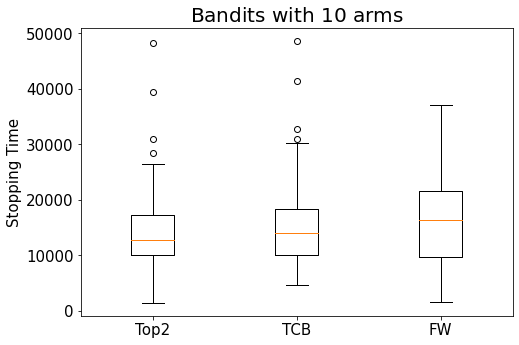

In [ ]:
online_samples_list = []
online_samples_list = [result_top2]
online_samples_list += [result_tcb]
online_samples_list += [result_fw]

fig = plt.figure()

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(online_samples_list)
plt.xticks([1, 2, 3], ['Top2', 'TCB', 'FW'])
# plt.xlabel('Top2, TCB, FW', fontsize=15)
plt.ylabel('Stopping Time', fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title(r'Bandits with $10$ arms'.format(1), fontsize=20)


# show plot
plt.show()